# **<i>Документация</i>**
<br>

### **<i>PAM(k=3, metric="euclidean", max_iter = 300, tol=0.001)</i>**
<br>

### **<i>PARAMETERS</i>**

<ul>
  <li><h3><i>k: int, default=3</i></h3></li>
        The number of clusters to form as well as the number of centroids to generate.
  <li><h3><i>metric: str, default='euclidean'</i></h3></li>
        Metric used to compute the linkage.
  <li><h3><i>max_iter: int, default=300</i></h3></li>
        Maximum number of iterations of the k-means algorithm for a single run.
  <li><h3><i>tol: float, default=1e-3</i></h3></li>
        Relative tolerance with regards to inertia to declare convergence.
</ul>

### **<i>ATTRIBUTES</i>**

<ul>
  <li><h3><i>inertia_: float</i></h3></li>
        Sum of squared distances of samples to their closest cluster medoid.
  <li><h3><i>medoids_: list of len (n_clusters)</i></h3></li>
        Coordinates of cluster medoids. If the algorithm stops before fully converging (see tol and max_iter), these will not be consistent with labels_.
  <li><h3><i>labels_: ndarray of shape (n_samples,)</i></h3></li>
        Labels of each point.      
</ul>
<br>
<br>

### **<i>METHOD fit(self, X)</i>**
#### Compute partiton around medoids clustering.
### **<i>PARAMETERS</i>**
<ul>
<li><h3><i>X: array-like or sparse matrix, shape=(n_samples, n_features)</i></h3></li>
        Training instances to cluster.
</ul>
<br>

### **<i>RETURNS</i>**
<ul>
<li><h3><i>self</i></h3></li>
        Fitted estimator.
</ul>


## Особенности работы алгоритма описаны комментариями непосредственно в коде

In [4]:
import random
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist

from sklearn.base import BaseEstimator
from itertools import cycle
from math import hypot

In [14]:
def medoid_distribution(med_ind, data):
    dist_vector = np.zeros(len(data)) # ближайшая медоида для каждого объекта
    dist_matr = np.zeros((len(data), len(med_ind))) # матрица расстояний
    target = np.Inf # значение целевой функции
    min_dists = np.zeros(len(data))
    
    for idx, p in enumerate(data):
        ''' поиск для каждого объекта данных ближайшего к нему медоида,
        приписание объекта к этому медоиду: "в матрице расстояний" индексу данного объекта
        присваивается индекс медоида'''
        dist_matr[idx] = [np.linalg.norm(p - data[q]) for q in med_ind]
        dist_vector[idx] = med_ind[np.asarray(dist_matr[idx]).argmin()]
        min_dists[idx] = min(dist_matr[idx])
        
    target = sum(min_dists)
    return dist_vector, dist_matr, min_dists, target

def medoid_remake(med_ind, dist_vector, data):
    new_meds = []
    for m in med_ind:
        clust = np.where(dist_vector == m) # индекс тех эл-в в данных, медоид которых равен m
        clust = clust[0] # функция np.where() возвращает tuple из 1 эл-та, содержащего array
        distances = [] # здесь будут суммы р-й каждой точки до всех остальных в этом кластере
        for i in clust:
            distances.append(sum([np.linalg.norm(data[i] - data[q]) for q in clust if q != i]))
        new_meds.append(clust[np.asarray(distances).argmin()])
    return new_meds



class PAM(BaseEstimator):

        
    def __init__(self, k=3, metric="euclidean", max_iter = 300, tol=0.001):
        self.k = k
        self.metric = metric
        self.max_iter = max_iter
        self.tol = tol
        
    def fit(self, dt):
        
        # преобразование данных из dataframe, если необходимо в массив списков характеристик каждого объекта
        if type(dt) == pd.core.frame.DataFrame:
            data = dt[col].values.tolist()
        else:
            data = dt

        # Шаг 1
        med_ind = set() # рандомная генерация индексов медоидов
        while len(med_ind) != self.k:
            med_ind.add(random.randint(0, len(data) - 1))
        med_ind = list(med_ind)
            
        # Шаг 2 матрица расстояний
        dist_vector, dist_matr, min_dists, TARGET_INIT = medoid_distribution(med_ind, data)
        # TARGET_INIT - начальное значение целевой ф-и, с которым будем сравнивать её изменения
        
        # Шаг 3 пересчёт расстояний и медоид
        for i in range(self.max_iter):
            med_ind = medoid_remake(med_ind, dist_vector, data)
            dist_vector, dist_matr, min_dists, target = medoid_distribution(med_ind, data)
            if TARGET_INIT - target < self.tol:
                break
        
        
        self.inertia_ = target
        self.medoids_ = med_ind
        self.labels_ = dist_vector
        
    
    def fit_predict(self, dt):
        self.fit(dt)
        return self.labels_
#         return self.inertia_, self.medoids_, self.labels_

In [6]:
import sklearn.datasets as ds

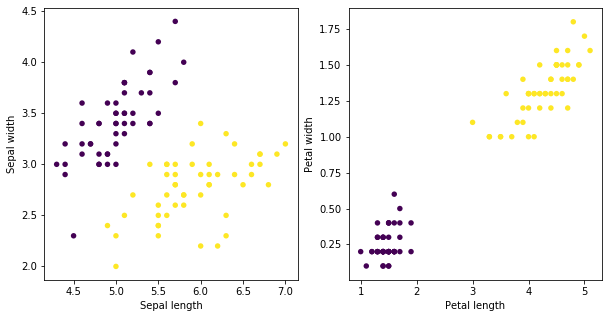

In [8]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap='viridis', lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap='viridis', lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

In [24]:
pred_iris = PAM(k=2).fit_predict(x_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 1.00


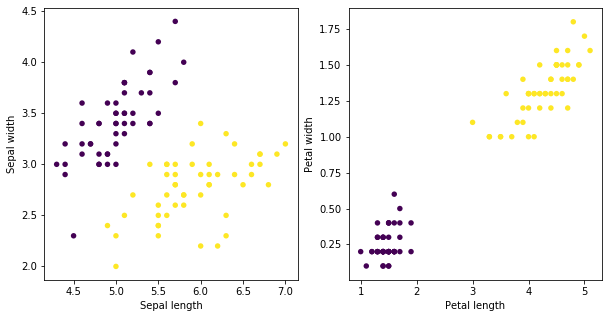

In [25]:
# Graph for self-written algorithm

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=pred_iris, cmap='viridis', lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=pred_iris, cmap='viridis', lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

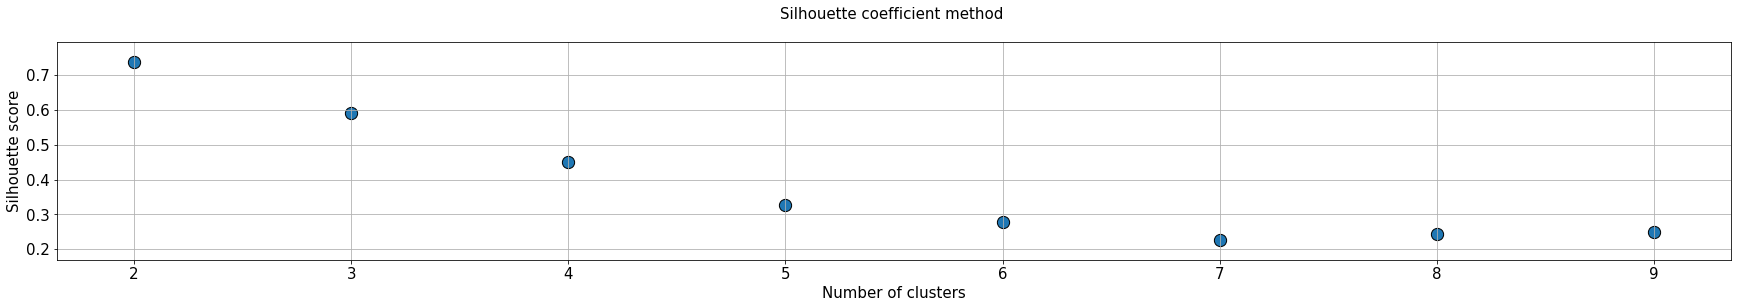

In [22]:
# подбор параметров методом и силуэта
from sklearn.metrics import silhouette_score


pam_silhouette = []
for i in range(2,10):
    preds = PAM(k=i).fit_predict(x_iris)    
    silhouette = silhouette_score(x_iris, preds)
    pam_silhouette.append(silhouette)


plt.figure(figsize=(30, 4))
plt.title("Silhouette coefficient method \n", fontsize=15)
plt.scatter(x=[i for i in range(2,10)], y=pam_silhouette, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters", fontsize=15)
plt.ylabel("Silhouette score", fontsize=15)
plt.xticks([i for i in range(2,10)], fontsize=15)
plt.yticks(fontsize=15)
plt.show()